In [1]:
#Deepfool算法示例
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2

b=Variable(torch.FloatTensor([2]), requires_grad=True)
a=b*b
print(a)
print(b)

a.backward()

print(b.grad.data)

tensor([4.], grad_fn=<ThMulBackward>)
tensor([2.], requires_grad=True)
tensor([4.])


In [2]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    import matplotlib.pyplot as plt
    plt.figure()

    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="../picture/test_im1.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = Variable(torch.from_numpy(img).to(device).float())
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

orig_label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(orig_label))


torch.Size([1, 3, 224, 224])
label=88


In [4]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False
    
#最大迭代次数
epochs=100
#used as a termination criterion to prevent vanishing updates
overshoot=0.02
#类别数
num_classes=1000

# forward 
output = model(img)


input_shape = img.cpu().detach().numpy().shape
w = np.zeros(input_shape)
r_tot = np.zeros(input_shape)

for epoch in range(epochs):
    
    scores=model(img).data.cpu().numpy()[0]
    label=np.argmax(scores)
    print("epoch={} label={} score={}".format(epoch,label,scores[label]))
    
    #如果无定向攻击成功
    if label != orig_label:
        break
   
    pert = np.inf
    output[0, orig_label].backward(retain_graph=True)
    grad_orig = img.grad.data.cpu().numpy().copy()

    for k in range(1, num_classes):
        
        if k == orig_label:
            continue
        
        #梯度清零
        zero_gradients(img)
        
        output[0, k].backward(retain_graph=True)
        cur_grad = img.grad.data.cpu().numpy().copy()

        # set new w_k and new f_k
        w_k = cur_grad - grad_orig
        f_k = (output[0, k] - output[0, orig_label]).data.cpu().numpy()

        pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

        # 选择pert最小值
        if pert_k < pert:
            pert = pert_k
            w = w_k

    # 计算 r_i 和 r_tot
    r_i =  (pert+1e-8) * w / np.linalg.norm(w)
        
    r_tot = np.float32(r_tot + r_i)
    
    img.data=img.data + (1+overshoot)*torch.from_numpy(r_tot).to(device)

epoch=0 label=88 score=18.340900421142578
epoch=1 label=88 score=13.300100326538086
epoch=2 label=879 score=12.384634017944336


(3, 224, 224)


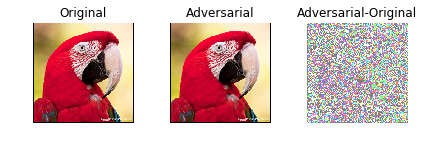

In [6]:
adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

show_images_diff(orig,orig_label,adv,label)